In [10]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
from gpzoo.gp import SVGP, VNNGP
from gpzoo.kernels import NSF_RBF, RBF
from gpzoo.likelihoods import GaussianLikelihood, NSF2
import squidpy as sq
import numpy as np
#from gpzoo.utilities import train
import time

In [11]:
new_model=False

In [12]:
adata = sq.datasets.visium_hne_adata()

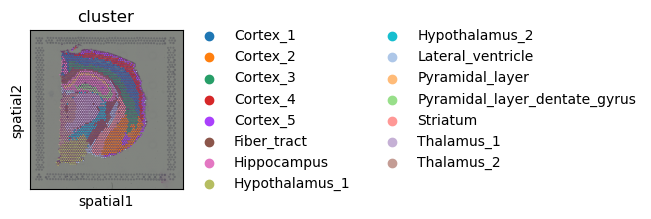

In [13]:
sq.pl.spatial_scatter(adata, color="cluster")

In [14]:
Y_sums = np.array(np.sum(adata.raw.X > 0, axis=0))[0]
Y = np.array(adata.raw.X[:, Y_sums>200].todense(), dtype=int).T
X = adata.obsm['spatial']

In [15]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)
print(X.shape)
print(Y.shape)

torch.Size([2688, 2])
torch.Size([11925, 2688])


In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [17]:
def train(model, optimizer, X, y, device, steps=200, E=20, **kwargs):
    losses = []

    means = []
    scales = []
    idxs = []

    for it in tqdm(range(steps)):

        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X=X, E=E, **kwargs)
        print("Shape of y:", y.shape)
        print("Expected shape by model output:", pY.mean.shape)  # Assuming pY is a distribution


        logpY = pY.log_prob(y)

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))

        loss = -ELBO
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if (it%10)==0:
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())

    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()

    return losses, means, scales

In [19]:
# initialize dictionary
L = 10
M = 1000

idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
kernel = NSF_RBF(L=L, sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, M=M, jitter=1e-1, K=5)
gp.Lu = nn.Parameter(torch.eye(M).expand(L, M, M).clone())
gp.mu = nn.Parameter(torch.randn((L, M)))
gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=True) # ADJUST


model = NSF2(gp=gp, y=Y, L=L)
model.to(device)
X_train = X.to(device)
Y_train = Y.to(device)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-e)

model.to(device)
start_time = time.time()
print(f'NUM INDUCING POINTS (M): {M}')
print(f'NUM NEIGHBORS (K): {5}')
print(f'NUM GPS (L): {L}')
print(f'X_SHAPE: {X.shape}')
print(f'Y_SHAPE: {Y.shape}')
losses, means, scales = train(model, optimizer, X_train, Y_train, device, steps=1000, E=10)
end_time = time.time()
final_time = end_time - start_time

# save losses
fig1, ax1 = plt.subplots()
plt.plot(losses)
#fig1.savefig(f'{alg}_N={num_N[i]}_Z={M}_loss.png')
#plt.close(fig1)

NUM INDUCING POINTS (M): 1000
NUM NEIGHBORS (K): 5
NUM GPS (L): 10
X_SHAPE: torch.Size([2688, 2])
Y_SHAPE: torch.Size([11925, 2688])


/var/folders/dv/w3pzlt_11hdcpw6gskd45b_80000gn/T/ipykernel_37078/4119051810.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=True) # ADJUST


  0%|          | 0/1000 [00:00<?, ?it/s]

Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])
Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])
Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])
Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])
Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])
Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])
Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])
Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])
Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])
Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])


KeyboardInterrupt: 